In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from tqdm import tqdm

from qec_generator import CircuitParams
from simulate_qec_rounds_stim import experiment_run, monte_carlo_experiment_run
from stim_lib.scheduled_circuit import generate_scheduled
from scipy.optimize import curve_fit

In [3]:
matplotlib.rcParams['font.size'] = 14

In [4]:
def log_err_fit(rounds, e_logical):
    return 0.5*(1 - (1-2*e_logical)**rounds)

In [5]:
cparams = CircuitParams(t1=15e3,
                t2=8e3,
                single_qubit_gate_duration=20,
                two_qubit_gate_duration=20,
                single_qubit_depolarization_rate=1e-3,
                two_qubit_depolarization_rate=5e-3,
                meas_duration=550,
                reset_duration=None,
                reset_latency=40,
                meas_induced_dephasing_enhancement=3)


distance_vec = [3, 5]
rounds_vec = np.arange(2, 14, 2)
shots = 20000

In [6]:
def get_error_rate_log_err_vec(reset_strategy):
#     circ, cont = generate_scheduled(
#     code_task='surface_code:rotated_memory_z',  # looks ok
#     distance=3,
#     rounds=1,
#     params=cparams
#     )
#     print(circ)
    log_err_vec = []
    error_rate = []
    task = 'surface_code:rotated_memory_z'  # looks ok
    # task = 'surface_code:unrotated_memory_z'  # looks ok

    print(cparams.reset_duration)
    for distance in distance_vec:
        error_rate.append([])
        print(f'starting distance = {distance}')
        for rounds in tqdm(rounds_vec):
            error_rate[-1].append(1 - monte_carlo_experiment_run(task, distance, rounds, cparams,
                                      shots=shots, reset_strategy=reset_strategy))
        log_err, pcov = curve_fit(log_err_fit, rounds_vec, error_rate[-1], p0=0)
        log_err_vec.append(log_err)

    log_err_vec = np.array(log_err_vec).squeeze()
    error_rate = np.array(error_rate)
    return error_rate, log_err_vec


def plot_lambda(error_rate, log_err_vec, title, filename):
    plt.figure(figsize=(6, 5))
    for i, distance in enumerate(distance_vec):
        plt.plot(rounds_vec, error_rate[i], 'o', label=f'distance={distance}')
        plt.plot(rounds_vec, log_err_fit(rounds_vec, log_err_vec[i]), '--')

    plt.legend()
    plt.xlabel('number of rounds')
    plt.ylabel('logical error rate')
    plt.title(title)
    plt.ylim((0, 0.5))
    print(f'1/Lambda = {log_err_vec[1] / log_err_vec[0]}')
    plt.savefig(filename)

## Extracting 1/Lambda with APT

In [7]:
cparams.reset_duration=300
error_rate_ar, log_err_vec_ar = get_error_rate_log_err_vec('AR')

  0%|                                                                                                                                           | 0/6 [00:00<?, ?it/s]

300
starting distance = 3


  0%|                                                                                                                                           | 0/6 [00:00<?, ?it/s]

starting distance = 5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [1:09:29<00:00, 694.99s/it]


1/Lambda = 0.9555254032116834


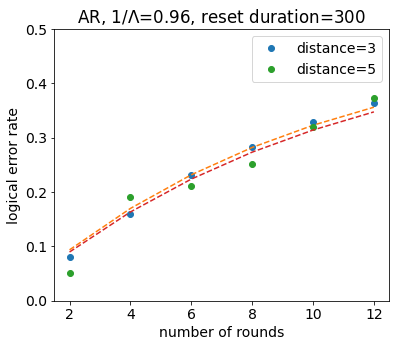

In [8]:
plot_lambda(
    error_rate_ar,
    log_err_vec_ar,
    f'AR, $1/\Lambda$={log_err_vec_ar[1] / log_err_vec_ar[0]:.2f}, reset duration={cparams.reset_duration}',
    'AR_RD=300_GE_hi.svg'
)

## Active parity tracking benefit

In [9]:
cparams.reset_duration=0
error_rate_apt, log_err_vec_apt = get_error_rate_log_err_vec('APT')

  0%|                                                                                                                                           | 0/6 [00:00<?, ?it/s]

0
starting distance = 3


  0%|                                                                                                                                           | 0/6 [00:00<?, ?it/s]

starting distance = 5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [1:19:39<00:00, 796.54s/it]


1/Lambda = 0.8210995856257294


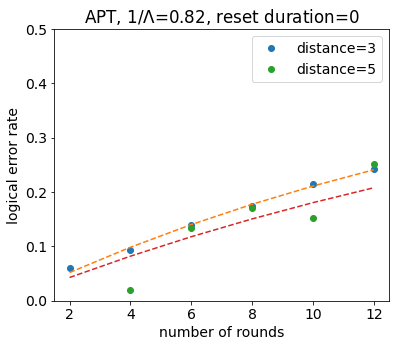

In [10]:
plot_lambda(
    error_rate_apt,
    log_err_vec_apt,
    f'APT, $1/\Lambda$={log_err_vec_apt[1] / log_err_vec_apt[0]:.2}, reset duration={cparams.reset_duration}',
    'APT_RD=0_GE_hi.svg'
)

## What happens when there are no gate errors at all?

In [11]:
cparams.reset_duration = 0
cparams.single_qubit_depolarization_rate = 1e-4
cparams.two_qubit_depolarization_rate = 1e-4
error_rate_apt_low, log_err_vec_apt_low = get_error_rate_log_err_vec('APT')

  0%|                                                                                                                                           | 0/6 [00:00<?, ?it/s]

0
starting distance = 3


  0%|                                                                                                                                           | 0/6 [00:00<?, ?it/s]

starting distance = 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [1:51:31<00:00, 1115.18s/it]


1/Lambda = 0.6270785097894845


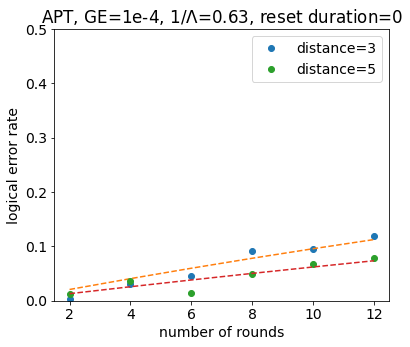

In [12]:
plot_lambda(
    error_rate_apt_low,
    log_err_vec_apt_low,
    f'APT, GE=1e-4, $1/\Lambda$={log_err_vec_apt_low[1] / log_err_vec_apt_low[0]:.2}, reset duration={cparams.reset_duration}',
    'APT_RD=0_GE_1e-4.svg'
)

In [13]:
cparams.reset_duration=300
cparams.single_qubit_depolarization_rate = 1e-4
cparams.two_qubit_depolarization_rate = 1e-4
error_rate_ar_low, log_err_vec_ar_low = get_error_rate_log_err_vec('AR')

  0%|                                                                                                                                           | 0/6 [00:00<?, ?it/s]

300
starting distance = 3


  0%|                                                                                                                                           | 0/6 [00:00<?, ?it/s]

starting distance = 5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [1:05:39<00:00, 656.59s/it]


1/Lambda = 0.7356563252785839


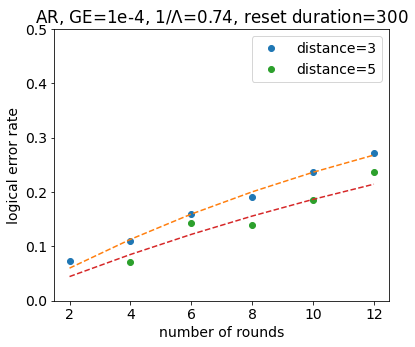

In [14]:
plot_lambda(
    error_rate_ar_low,
    log_err_vec_ar_low,
    f'AR, GE=1e-4, $1/\Lambda$={log_err_vec_ar_low[1] / log_err_vec_ar_low[0]:.2}, reset duration={cparams.reset_duration}',
    'AR_RD=300_GE_1e-4.svg'
)